In [67]:

import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from itertools import chain


In [68]:

# Load annotated utterances from Ego4D and YouTube
split_paths = [
    "Ego4D/split/train.json",
    "Ego4D/split/val.json",
    "Ego4D/split/test.json",
    "Youtube/split/train.json",
    "Youtube/split/val.json",
    "Youtube/split/test.json"
]

utterances = []
for path in split_paths:
    if os.path.exists(path):
        with open(path, "r", encoding="utf-8") as f:
            games = json.load(f)
            for game in games:
                for utt in game["Dialogue"]:
                    utt["Game_ID"] = game["Game_ID"]
                    utt["YT_ID"] = game.get("YT_ID", "")
                    utt["video_name"] = game.get("video_name", "")
                    utt["split"] = os.path.basename(path).replace(".json", "")
                    utt["source"] = "Ego4D" if "Ego4D" in path else "Youtube"
                    utterances.append(utt)

df = pd.DataFrame(utterances)
df['utterance_length'] = df['utterance'].str.split().apply(len)
df['annotation'] = df['annotation'].apply(lambda x: x if isinstance(x, list) else [])
df['speaker'] = df['speaker'].str.strip().str.lower()
df['Game_ID'] = df['Game_ID'].str.strip().str.lower()
df['source'] = df['source'].str.strip()
df.head()
df.to_csv('df.csv', index=False) 

In [69]:

# Load all outcome data from previously extracted folders
outcome_paths = [
    "Ego4D/vote_outcome_ego4d",
    "Youtube/vote_outcome_youtube_released"
]

outcomes = []
for path in outcome_paths:
    src = "Ego4D" if "ego4d" in path.lower() else "Youtube"
    for filename in os.listdir(path):
        if filename.endswith(".json"):
            with open(os.path.join(path, filename), "r", encoding="utf-8") as f:
                content = json.load(f)
                for game_id, game in content.items():
                    players = game.get("playerNames", [])
                    votes = game.get("votingOutcome", [])
                    start_roles = game.get("startRoles", [])
                    end_roles = game.get("endRoles", [])
                    for i, name in enumerate(players):
                        vote_idx = votes[i] if i < len(votes) and votes[i] != "NA" else None
                        voted_for = players[vote_idx] if isinstance(vote_idx, int) and vote_idx < len(players) else None
                        outcomes.append({
                            "Game_ID": game_id.strip().lower(),
                            "speaker": name.strip().lower(),
                            "source": src,
                            "voted_for": voted_for,
                            "voted_index": vote_idx,
                            "start_role": start_roles[i] if i < len(start_roles) else None,
                            "end_role": end_roles[i] if i < len(end_roles) else None
                        })

outcome_df = pd.DataFrame(outcomes)
outcome_df.to_csv('outcome_df.csv', index=False) 

In [70]:

# Merge using stricter keys
merged_df = df.merge(outcome_df, on=["Game_ID", "speaker", "source"], how="left")

# Add survival column
merged_df['survived'] = merged_df['start_role'] == merged_df['end_role']
merged_df.head()
merged_df.to_csv('merged_df.csv', index=False) 

In [81]:
# Load the full exploded_df again
exploded_df = pd.read_csv("exploded_df.csv")

# Clean annotations
exploded_df["is_strategic"] = exploded_df["annotation"] != "No Strategy"

# Convert timestamps to minutes
def timestamp_to_min(ts):
    try:
        minutes, seconds = map(int, str(ts).split(":"))
        return minutes + seconds / 60
    except:
        return None

exploded_df["time_min"] = exploded_df["timestamp"].apply(timestamp_to_min)

# Compute general utterance stats
total_utterances = exploded_df[["Game_ID", "Rec_Id"]].drop_duplicates().shape[0]
strategic_utterances = exploded_df[exploded_df["is_strategic"]][["Game_ID", "Rec_Id"]].drop_duplicates().shape[0]
percent_strategic = (strategic_utterances / total_utterances) * 100
avg_utterance_length = exploded_df[["Game_ID", "Rec_Id", "utterance_length"]].drop_duplicates()["utterance_length"].mean()
utterance_length_std = exploded_df[["Game_ID", "Rec_Id", "utterance_length"]].drop_duplicates()["utterance_length"].std()
max_utterance_length = exploded_df["utterance_length"].max()

# Strategy stats
unique_strategies = exploded_df["annotation"].nunique()
top_strategies = exploded_df["annotation"].value_counts().head(5)

# Speaker stats
speaker_counts = exploded_df["speaker"].value_counts()
most_talkative = speaker_counts.idxmax()
utterances_per_speaker = speaker_counts.mean()

# Role and survival
exploded_df["survived"] = exploded_df["start_role"] == exploded_df["end_role"]
survival_rate = exploded_df[["Game_ID", "speaker", "survived"]].drop_duplicates()["survived"].mean()

# Avg strategy count per utterance (counting per unique utterance)
strategy_per_utt = exploded_df[exploded_df["is_strategic"]].groupby(["Game_ID", "Rec_Id"]).size().mean()

# Anomaly checks — long utterances and strategy-only/no-strategy utterances
anomalously_long_utterances = exploded_df[exploded_df["utterance_length"] > 40][["speaker", "utterance", "utterance_length"]]


# Recalculate average number of unique strategies per utterance (corrected method)
corrected_strategy_per_utt = (
    exploded_df[exploded_df["annotation"] != "No Strategy"]
    .groupby(["Game_ID", "Rec_Id"])["annotation"]
    .apply(lambda x: len(set(x)))
    .mean()
)


# Strategy burst detection — utterances with more than 3 strategies
multi_strategy_utterances = (
    exploded_df.groupby(["Game_ID", "Rec_Id"])["annotation"]
    .apply(lambda x: len(set(x)) > 3)
    .sum()
)

# Timing — approximate game durations
game_durations = exploded_df.groupby("Game_ID")["time_min"].max()
avg_game_duration = game_durations.mean()
max_game_duration = game_durations.max()




# Rebuild the overview with corrected value
overview = {
    "total_utterances": total_utterances,
    "strategic_utterances": strategic_utterances,
    "percent_strategic": round(percent_strategic, 2),
    "avg_utterance_length": round(avg_utterance_length, 2),
    "utterance_length_std": round(utterance_length_std, 2),
    "max_utterance_length": max_utterance_length,
    "unique_strategies": unique_strategies,
    "top_5_strategies": top_strategies.to_dict(),
    "unique_speakers": len(speaker_counts),
    "most_talkative_speaker": most_talkative,
    "avg_utterances_per_speaker": round(utterances_per_speaker, 2),
    "survival_rate": round(survival_rate * 100, 2),
    "avg_strategies_per_utterance": round(corrected_strategy_per_utt, 2),
    "long_utterance_examples": anomalously_long_utterances.head(3).to_dict(orient="records"),
    "utterances_with_many_strategies": multi_strategy_utterances,
    "avg_game_duration_min": round(avg_game_duration, 2),
    "max_game_duration_min": round(max_game_duration, 2)
}

overview


{'total_utterances': 2621,
 'strategic_utterances': 2117,
 'percent_strategic': 80.77,
 'avg_utterance_length': 8.8,
 'utterance_length_std': 8.23,
 'max_utterance_length': 310,
 'unique_strategies': 7,
 'top_5_strategies': {'No Strategy': 9785,
  'Interrogation': 3998,
  'Accusation': 3470,
  'Defense': 3162,
  'Evidence': 2180},
 'unique_speakers': 77,
 'most_talkative_speaker': 'justin',
 'avg_utterances_per_speaker': 328.65,
 'survival_rate': 48.66,
 'avg_strategies_per_utterance': 3.18,
 'long_utterance_examples': [{'speaker': 'kaelan',
   'utterance': "Okay. Dan is a very deceptive guy and is very good at... I don't want to say gaslight because that sounds real mean, but you're very good at convincing people of things. You seem to be self-sabotaging hard, but it could be the double.",
   'utterance_length': 44},
  {'speaker': 'kaelan',
   'utterance': "Okay. Dan is a very deceptive guy and is very good at... I don't want to say gaslight because that sounds real mean, but you're v

## 🧾 Dataset Overview – Werewolf Persuasion Games

### 🗣️ Utterances
- **Total utterances**: 2,621  
- **Strategic utterances**: 2,117  
- **Percent strategic**: 80.77%  
- **Average length (words)**: 8.8  
- **Standard deviation**: 8.23  
- **Maximum length**: 310 words

---

### 🧠 Strategies
- **Unique strategies**: 7  
- **Top 5 most used**:  
  - Interrogation (3,998)  
  - Accusation (3,470)  
  - Defense (3,162)  
  - Evidence (2,180)  
  - Identity Declaration  
- **Average unique strategies per strategic utterance**: 3.18  
- **Utterances with 4+ strategy types**: 1,171

---

### 👤 Speakers
- **Unique speakers**: 77  
- **Most talkative speaker**: *justin*  
- **Average utterances per speaker**: 328.65

---

### 🎭 Roles & Survival
- **Overall survival rate**: 48.66%

---

### 🧪 Notable Anomalies
- **Super long utterances** (examples):
  - *kaelan*: “Okay. Dan is a very deceptive guy...” (44 words)  
  - *margaret*: “So the question is, if he really was the Seer...” (51 words)
- **Utterances with many strategies (4 or more)**: 1,171

---

### ⏱️ Timing
- **Average game duration**: 7.57 minutes  
- **Longest game**: 17.75 minutes

In [71]:

# Explode annotation for per-strategy view
exploded_df = merged_df.explode("annotation")
exploded_df = exploded_df.drop_duplicates(subset=["utterance", "annotation", "Game_ID", "speaker"])
exploded_df = exploded_df[exploded_df['annotation'].notna()]
exploded_df.head()
exploded_df.to_csv('exploded_df.csv', index=False) 

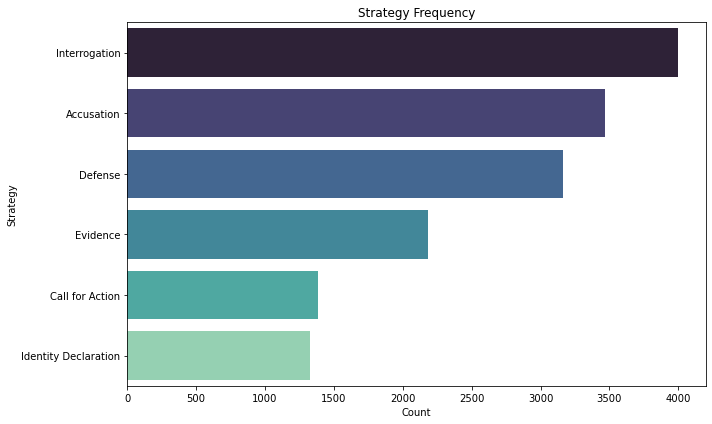

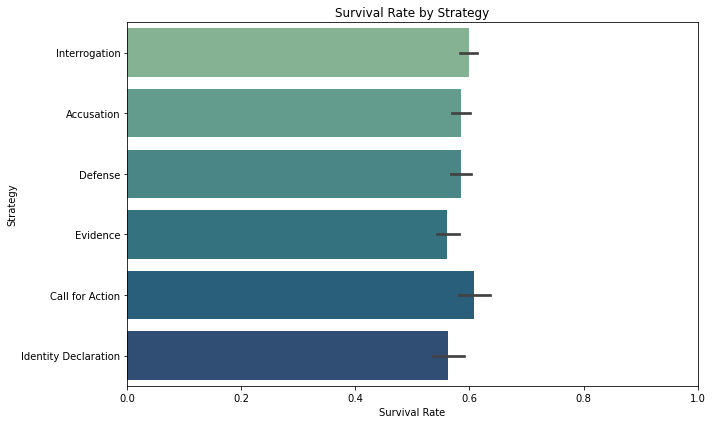

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ======================
# 1. Strategy Frequency
# ======================
strategic = exploded_df[exploded_df['annotation'] != "No Strategy"]

plt.figure(figsize=(10, 6))
sns.countplot(
    data=strategic,
    y="annotation",
    order=strategic['annotation'].value_counts().index,
    palette="mako"
)
plt.title("Strategy Frequency")
plt.xlabel("Count")
plt.ylabel("Strategy")
plt.tight_layout()
plt.show()


# ==========================
# 2. Survival by Strategy
# ==========================
survival_by_strategy = strategic[strategic['survived'].notnull()]

plt.figure(figsize=(10, 6))
sns.barplot(
    data=survival_by_strategy,
    x="survived",
    y="annotation",
    estimator=lambda x: sum(x) / len(x),
    order=survival_by_strategy['annotation'].value_counts().index,
    palette="crest"
)
plt.title("Survival Rate by Strategy")
plt.xlabel("Survival Rate")
plt.ylabel("Strategy")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

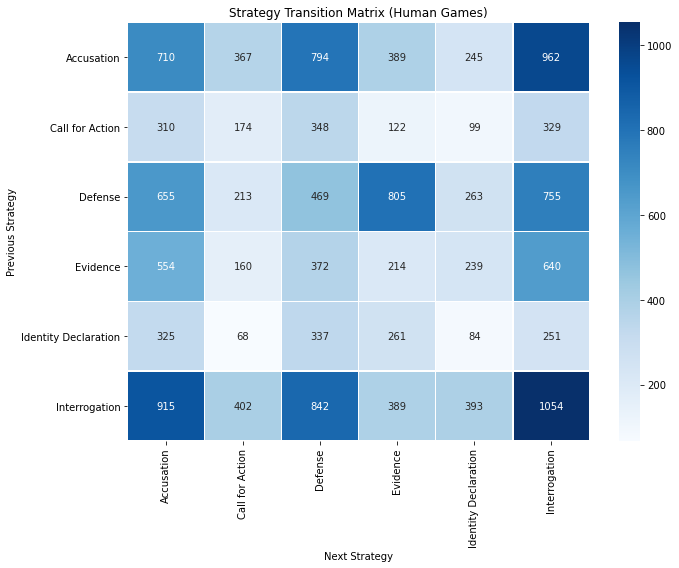

In [73]:
# Filter for non-null and non-"No Strategy" annotations
df_filtered = exploded_df[exploded_df['annotation'].notnull() & (exploded_df['annotation'] != 'No Strategy')].copy()

# Sort to preserve conversation order
df_filtered = df_filtered.sort_values(by=["Game_ID", "Rec_Id"])

# Create annotation transition pairs within each game
from itertools import tee

transitions = []
for _, group in df_filtered.groupby("Game_ID"):
    annotations = group["annotation"].tolist()
    a, b = tee(annotations)
    next(b, None)
    transitions += list(zip(a, b))

# Build transition DataFrame and count transitions
trans_df = pd.DataFrame(transitions, columns=["from", "to"])
transition_matrix = trans_df.value_counts().unstack(fill_value=0)

# Plot the transition matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("Strategy Transition Matrix (Human Games)")
plt.xlabel("Next Strategy")
plt.ylabel("Previous Strategy")
plt.tight_layout()
plt.show()


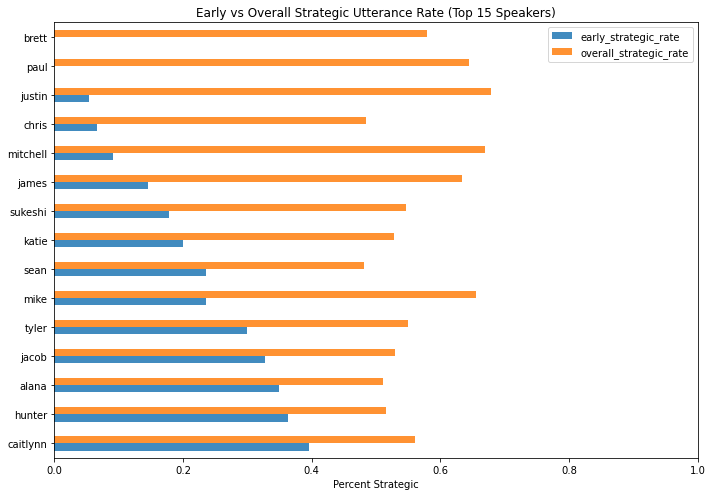

In [74]:
# Re-rank utterances per speaker per game
exploded_df["utterance_rank"] = exploded_df.groupby(["Game_ID", "speaker"])["Rec_Id"].rank(method="first")

# Flag strategic utterances
exploded_df["is_strategic"] = exploded_df["annotation"] != "No Strategy"

# Filter to first 5 utterances per speaker per game
early_df = exploded_df[exploded_df["utterance_rank"] <= 5]

# Compute early strategic rate per speaker
early_strat_rate = (
    early_df.groupby("speaker")["is_strategic"]
    .mean()
    .to_frame("early_strategic_rate")
)

# Compute overall strategic rate per speaker
overall_rate = (
    exploded_df.groupby("speaker")["is_strategic"]
    .mean()
    .to_frame("overall_strategic_rate")
)

# Combine both metrics and filter for top 15 speakers by total utterances
speaker_counts = exploded_df["speaker"].value_counts().head(15).index
strategy_timing_df = early_strat_rate.join(overall_rate).loc[speaker_counts]

# Plot the updated bar chart
strategy_timing_df = strategy_timing_df.sort_values("early_strategic_rate", ascending=False)
strategy_timing_df[["early_strategic_rate", "overall_strategic_rate"]].plot.barh(
    figsize=(10, 7), alpha=0.85
)
plt.title("Early vs Overall Strategic Utterance Rate (Top 15 Speakers)")
plt.xlabel("Percent Strategic")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


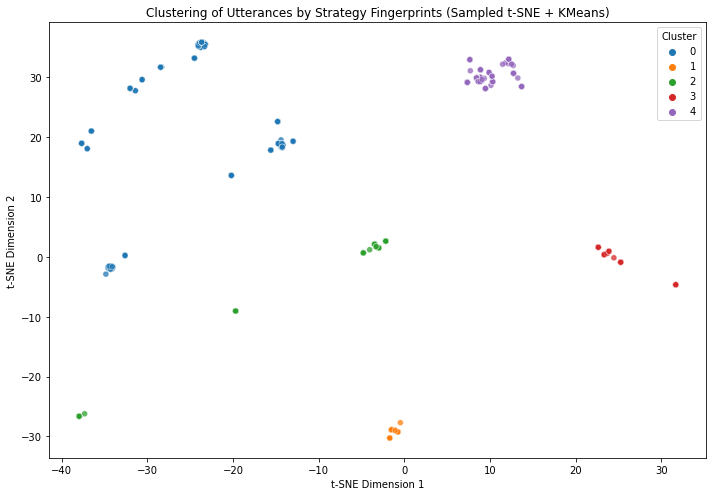

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt




# Sample the data first to speed up t-SNE
sampled = (
    exploded_df[exploded_df['annotation'] != "No Strategy"]
    .groupby(["Game_ID", "Rec_Id", "utterance"])["annotation"]
    .apply(lambda ann: " ".join(sorted(set(ann))))
    .reset_index()
    .sample(2000, random_state=42)
)

# Vectorize strategy fingerprints using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(sampled["annotation"])

# KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
sampled["cluster"] = kmeans.fit_predict(X)

# t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X.toarray())

sampled["tsne_1"] = X_tsne[:, 0]
sampled["tsne_2"] = X_tsne[:, 1]

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=sampled,
    x="tsne_1", y="tsne_2",
    hue="cluster", palette="tab10", alpha=0.75
)
plt.title("Clustering of Utterances by Strategy Fingerprints (Sampled t-SNE + KMeans)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


We wanted to see how people mix different persuasion strategies in the game, like accusing someone, asking questions, or defending themselves. Each line of dialogue can use one or more of these strategies. We turned each line into a kind of "fingerprint" based on which strategies it used. Then we used a technique called t-SNE to group similar fingerprints together and plot them. The result is a scatterplot where each dot is a line from the game, and dots that are close together use similar mixes of strategies.

What we saw is that the dots form clear clusters. That means people tend to use certain combinations of strategies together, not just random mixes. This gives us a strong baseline to compare against LLM-generated dialogue. If AI models are really imitating people, their dialogue should fall into similar clusters. If it doesn't, that tells us the models are missing some of the patterns real players use when trying to persuade others.

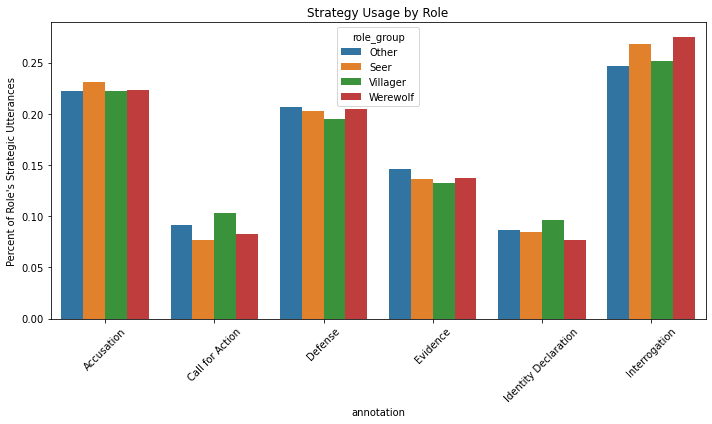

In [76]:
# Reload exploded_df in case of reset
exploded_df = pd.read_csv("exploded_df.csv")

# === Role-Aware Strategy Use ===

# Clean role labels
exploded_df["role_group"] = exploded_df["end_role"].fillna("Unknown").apply(
    lambda x: "Werewolf" if "Werewolf" in x else (
        "Seer" if "Seer" in x else (
            "Villager" if "Villager" in x else "Other"
        )
    )
)

# Filter to strategic utterances only
role_df = exploded_df[exploded_df["annotation"] != "No Strategy"]

# Count strategy usage by role
role_strat_counts = role_df.groupby(["role_group", "annotation"]).size().reset_index(name="count")

# Normalize by role total
role_totals = role_strat_counts.groupby("role_group")["count"].sum().reset_index(name="total")
role_strat_counts = role_strat_counts.merge(role_totals, on="role_group")
role_strat_counts["percent"] = role_strat_counts["count"] / role_strat_counts["total"]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=role_strat_counts,
    x="annotation", y="percent", hue="role_group"
)
plt.title("Strategy Usage by Role")
plt.ylabel("Percent of Role's Strategic Utterances")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


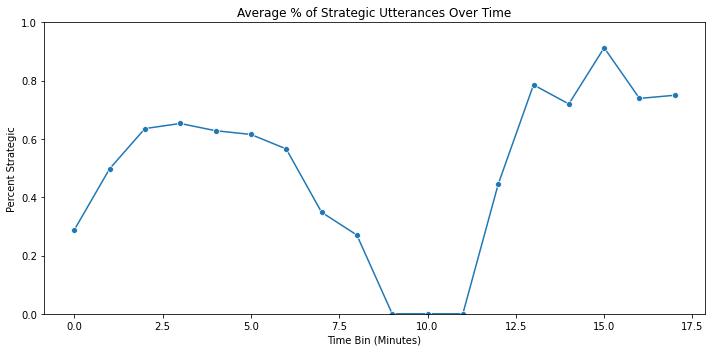

In [78]:
# Reload and prep data again in case of reset
exploded_df = pd.read_csv("exploded_df.csv")

# Convert timestamp to minutes (assuming MM:SS format)
def timestamp_to_min(ts):
    try:
        minutes, seconds = map(int, str(ts).split(":"))
        return minutes + seconds / 60
    except:
        return None

exploded_df["time_min"] = exploded_df["timestamp"].apply(timestamp_to_min)

# Keep only utterances with timing and strategic annotations
timing_df = exploded_df[exploded_df["annotation"].notnull() & exploded_df["time_min"].notnull()].copy()
timing_df["is_strategic"] = timing_df["annotation"] != "No Strategy"

# Bin into 1-minute intervals
timing_df["time_bin"] = timing_df["time_min"].apply(lambda x: int(x))

# Calculate % strategic per minute bin
grouped = (
    timing_df.groupby(["Game_ID", "time_bin"])["is_strategic"]
    .agg(["sum", "count"])
    .reset_index()
)
grouped["percent_strategic"] = grouped["sum"] / grouped["count"]

# Average across games
avg_over_time = grouped.groupby("time_bin")["percent_strategic"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=avg_over_time, x="time_bin", y="percent_strategic", marker="o")
plt.title("Average % of Strategic Utterances Over Time")
plt.xlabel("Time Bin (Minutes)")
plt.ylabel("Percent Strategic")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
